<a href="https://colab.research.google.com/github/taareek/resume_classification/blob/main/classification_with_LSTM_and_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### splitting training and validation set from training data and saving as csv

In [2]:
# train data folder path
train_path = '/content/drive/MyDrive/IC_Evaluation/archive/data/data'

# test data folder path
test_path = '/content/drive/MyDrive/IC_Evaluation/test'

In [4]:
import os
from os import walk
import pandas as pd
import csv

In [4]:
# function to get sub direcotories name and subdirectories name with path

def get_subdir_name_n_path(src_path):
  sub_dir = []
  sub_dir_w_path = []
  # getting sub-directories
  for (dir_path, dir_names, file_names) in walk(src_path):
    sub_dir.extend(dir_names)
    break
  # assigning sub-directories name
  for i in range(len(sub_dir)):
    sub_path = os.path.join(src_path+'/'+sub_dir[i]+'/')
    sub_dir_w_path.append(sub_path)

  return sub_dir, sub_dir_w_path

In [5]:
# checking the function with our root directory
train_fold_names, train_fold_paths = get_subdir_name_n_path(train_path)

# fold_names are resume classes, and fold_paths is path of that class
print(f"Total class or folder in the dataset:\n{train_fold_names}\n")
print(f"Path of those folders:\n{train_fold_paths}")

Total class or folder in the dataset:
['AUTOMOBILE', 'AVIATION', 'BUSINESS-DEVELOPMENT', 'APPAREL', 'ARTS', 'ACCOUNTANT', 'BPO', 'BANKING', 'ADVOCATE', 'AGRICULTURE', 'CONSTRUCTION', 'FITNESS', 'CONSULTANT', 'DIGITAL-MEDIA', 'ENGINEERING', 'DESIGNER', 'FINANCE', 'CHEF', 'HR', 'HEALTHCARE', 'PUBLIC-RELATIONS', 'INFORMATION-TECHNOLOGY', 'SALES', 'TEACHER']

Path of those folders:
['/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/AVIATION/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/BUSINESS-DEVELOPMENT/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/APPAREL/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/ARTS/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/ACCOUNTANT/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/BPO/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/BANKING/', '/content/drive/MyDrive/IC_Evaluation/archive/data/data/ADVOCATE/', '

In [6]:
# function to get files within a sub-directory

def get_subdir_files(src_dir):
  sub_files = []
  only_names = []
  for file in os.listdir(src_dir):
    if(os.path.isfile(os.path.join(src_dir, file))):
      file_name = os.path.join(src_dir, file)
      sub_files.append(file_name)
      only_names.append(file)
  return sub_files, only_names

In [ ]:
# now we wil get all training data, extract their information, and save in a csv file with label for further use

# first of all, I will create 24 sub-directory for 24 classes according to their name
for i in range(len(train_fold_names)):
  # getting the corresponding files of current sub-directory
  sub_resumes_path, sub_resumes_name = get_subdir_files(train_fold_paths[i])
  for k in range(len(sub_resumes_path)):
    print(sub_resumes_path[k], '===>' , train_fold_names[i])

/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/11887930.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/22946204.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/11797122.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/14455622.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/11152490.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/51508889.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/78357954.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/15790602.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/47487091.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/15100547.pdf ===> AUTOMOBILE
/content/drive/MyDrive/IC_Evaluation/archive/data/

In [5]:
# function to convert all characters in lower case and remove unnecessay characters and words
import re
import nltk

def preprocess_text(txt):
    # convert all characters in the string to lower case
    txt = txt.lower()
    # remove non-english characters, punctuation and numbers
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # remove RT and cc
    txt = re.sub('#\S+', '', txt)  # remove hashtags
    txt = re.sub('@\S+', '  ', txt)  # remove mentions
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace
    # tokenize word
    txt = nltk.tokenize.word_tokenize(txt)
    # remove stop words
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]

    return ' '.join(txt)

In [6]:
# initializing NLTK resources
# Initialize NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.2 MB/s eta 0:00:00


In [9]:
import PyPDF2
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

In [10]:
# function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

In [ ]:
# defining a list to store all train resumes text and labels
train_list = []

for i in range(len(train_fold_names)):
  # getting the corresponding files of current sub-directory
  sub_resumes_path, sub_resumes_name = get_subdir_files(train_fold_paths[i])
  for k in range(len(sub_resumes_path)):
    raw_text = extract_text_from_pdf(sub_resumes_path[k])
    processed_text = preprocess_text(raw_text)
    train_list.append([sub_resumes_path[k], processed_text, train_fold_names[i]])
  print(f"All train resumes for {train_fold_names[i]} are extracted and processed")
print("Completed...!")

All train resumes for AUTOMOBILE are extracted and processed
All train resumes for AVIATION are extracted and processed
All train resumes for BUSINESS-DEVELOPMENT are extracted and processed
All train resumes for APPAREL are extracted and processed
All train resumes for ARTS are extracted and processed
All train resumes for ACCOUNTANT are extracted and processed
All train resumes for BPO are extracted and processed
All train resumes for BANKING are extracted and processed
All train resumes for ADVOCATE are extracted and processed
All train resumes for AGRICULTURE are extracted and processed
All train resumes for CONSTRUCTION are extracted and processed
All train resumes for FITNESS are extracted and processed
All train resumes for CONSULTANT are extracted and processed
All train resumes for DIGITAL-MEDIA are extracted and processed
All train resumes for ENGINEERING are extracted and processed
All train resumes for DESIGNER are extracted and processed
All train resumes for FINANCE are e

In [ ]:
train_list[1]

['/content/drive/MyDrive/IC_Evaluation/archive/data/data/AUTOMOBILE/22946204.pdf',
 'highlights prog languages c yrs python yrs java yrs matlab simulink yrs r yrs processing yrs sql yrs plc yrs doc editing word ppt excel pages numbers keynote latex mechanical design autocad yrs solidworks yrs mechanical skills makerbot print laser cut mill drill lathe machine statistics softwares stata spss database softwares sql server yrs navicat yrs operating systems windows os x experience company name june current r product development engineer city design build tail sitter vtol vertical take landing uav unmanned aerial vehicle takes lands vertically travels horizontally main duties include limit aerodynamics modeling uav control system design mechanical manufacturing simulation tuning experiments company name may february research assistant city research assistant wharton school environment economics projects europe emission trading system eu etc main duties include large scale data collecting cl

In [ ]:
train_df = pd.DataFrame(train_list, columns=['path', 'resume', 'category'])
train_df.head(5)

,path,resume,category
0,/content/drive/MyDrive/IC_Evaluation/archive/d...,clinical data operations support analyst summa...,AUTOMOBILE
1,/content/drive/MyDrive/IC_Evaluation/archive/d...,highlights prog languages c yrs python yrs jav...,AUTOMOBILE
2,/content/drive/MyDrive/IC_Evaluation/archive/d...,automobile transporter professional summary de...,AUTOMOBILE
3,/content/drive/MyDrive/IC_Evaluation/archive/d...,proposal coordinator experience proposal coord...,AUTOMOBILE
4,/content/drive/MyDrive/IC_Evaluation/archive/d...,deputy principal executive profile results ori...,AUTOMOBILE


In [ ]:
from sklearn.model_selection import train_test_split
# splitting dataframe into train and validation set
train_resume, valid_resume = train_test_split(train_df, train_size = 0.8, shuffle= True, random_state = 1)

In [ ]:
# train data
train_resume.head(5)

,path,resume,category
468,/content/drive/MyDrive/IC_Evaluation/archive/d...,supervisor ountant professional summary motiva...,ACCOUNTANT
598,/content/drive/MyDrive/IC_Evaluation/archive/d...,program manager financial manager facilities m...,BANKING
1969,/content/drive/MyDrive/IC_Evaluation/archive/d...,information technology manager summary dedicat...,INFORMATION-TECHNOLOGY
125,/content/drive/MyDrive/IC_Evaluation/archive/d...,passenger services officer professional summar...,AVIATION
400,/content/drive/MyDrive/IC_Evaluation/archive/d...,activity specialist summary highly knowledgeab...,ARTS


In [ ]:
print(f"Total train samples: {len(train_resume)}")
print(f"Total validation samples: {len(valid_resume)}")
print(f"Total class in train resumes: {len(train_resume.category.unique())}")
print(f"Total class in validation resumes: {len(valid_resume.category.unique())}")

Total train samples: 1773
Total validation samples: 444
Total class in train resumes: 24
Total class in validation resumes: 24


In [ ]:
valid_resume.head(5)

,path,resume,category
725,/content/drive/MyDrive/IC_Evaluation/archive/d...,customer advocate summary obtain position comp...,ADVOCATE
1564,/content/drive/MyDrive/IC_Evaluation/archive/d...,co owner executive chef career focus performan...,CHEF
1422,/content/drive/MyDrive/IC_Evaluation/archive/d...,senior finance manager summary highly driven f...,FINANCE
1145,/content/drive/MyDrive/IC_Evaluation/archive/d...,director global digital marketing executive pr...,DIGITAL-MEDIA
1084,/content/drive/MyDrive/IC_Evaluation/archive/d...,consultant career focus business professional ...,CONSULTANT


In [ ]:
# now we will load the test data and a csv file for that too
# checking the function with our root directory
test_fold_names, test_fold_paths = get_subdir_name_n_path(test_path)

# fold_names are resume classes, and fold_paths is path of that class
print(f"Total class or folder in the dataset:\n{test_fold_names}\n")
print(f"Path of those folders:\n{test_fold_paths}")

Total class or folder in the dataset:
['AUTOMOBILE', 'AVIATION', 'BUSINESS-DEVELOPMENT', 'APPAREL', 'ARTS', 'ACCOUNTANT', 'BPO', 'BANKING', 'ADVOCATE', 'AGRICULTURE', 'CONSTRUCTION', 'FITNESS', 'CONSULTANT', 'DIGITAL-MEDIA', 'ENGINEERING', 'DESIGNER', 'FINANCE', 'CHEF', 'HR', 'HEALTHCARE', 'PUBLIC-RELATIONS', 'INFORMATION-TECHNOLOGY', 'SALES', 'TEACHER']

Path of those folders:
['/content/drive/MyDrive/IC_Evaluation/test/AUTOMOBILE/', '/content/drive/MyDrive/IC_Evaluation/test/AVIATION/', '/content/drive/MyDrive/IC_Evaluation/test/BUSINESS-DEVELOPMENT/', '/content/drive/MyDrive/IC_Evaluation/test/APPAREL/', '/content/drive/MyDrive/IC_Evaluation/test/ARTS/', '/content/drive/MyDrive/IC_Evaluation/test/ACCOUNTANT/', '/content/drive/MyDrive/IC_Evaluation/test/BPO/', '/content/drive/MyDrive/IC_Evaluation/test/BANKING/', '/content/drive/MyDrive/IC_Evaluation/test/ADVOCATE/', '/content/drive/MyDrive/IC_Evaluation/test/AGRICULTURE/', '/content/drive/MyDrive/IC_Evaluation/test/CONSTRUCTION/', '

In [ ]:
# defining a list to store all test resumes text and labels
test_list = []

for i in range(len(test_fold_names)):
  # getting the corresponding files of current sub-directory
  sub_resumes_path, sub_resumes_name = get_subdir_files(test_fold_paths[i])
  for k in range(len(sub_resumes_path)):
    raw_text = extract_text_from_pdf(sub_resumes_path[k])
    processed_text = preprocess_text(raw_text)
    test_list.append([sub_resumes_path[k], processed_text, test_fold_names[i]])
  print(f"All train resumes for {test_fold_names[i]} are extracted and processed..")
print("Completed...!")

All train resumes for AUTOMOBILE are extracted and processed..
All train resumes for AVIATION are extracted and processed..
All train resumes for BUSINESS-DEVELOPMENT are extracted and processed..
All train resumes for APPAREL are extracted and processed..
All train resumes for ARTS are extracted and processed..
All train resumes for ACCOUNTANT are extracted and processed..
All train resumes for BPO are extracted and processed..
All train resumes for BANKING are extracted and processed..
All train resumes for ADVOCATE are extracted and processed..
All train resumes for AGRICULTURE are extracted and processed..
All train resumes for CONSTRUCTION are extracted and processed..
All train resumes for FITNESS are extracted and processed..
All train resumes for CONSULTANT are extracted and processed..
All train resumes for DIGITAL-MEDIA are extracted and processed..
All train resumes for ENGINEERING are extracted and processed..
All train resumes for DESIGNER are extracted and processed..
All

In [ ]:
test_list[1]

['/content/drive/MyDrive/IC_Evaluation/test/AUTOMOBILE/63989974.pdf',
 'manager summary product manager bringing years project management skilled installation configuration migration implementation server platforms highlights enterprise platforms consumer software specialist project tracking hardware software upgrade planning product requirements documentation certified information security manager self directed budgeting resource management end end product lifecycles collaborative omplishments reduced incidence issues globally leading testing initiative improvement program experience current manager company name city state systems administrator hrs week administer windows server windows exchange server r ibm unix server administered nortel meridian pbx phone system add removing ounts provided hardware software support internal remote users configured monitor network security watch guard firewall troubleshooting network printer connectivity issues install network cabling phone jacks pu

In [ ]:
# making test dataframe
test_resume = pd.DataFrame(test_list, columns=['path', 'resume', 'category'])
test_resume.head(5)

,path,resume,category
0,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,general liability claim representative summary...,AUTOMOBILE
1,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,manager summary product manager bringing years...,AUTOMOBILE
2,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,legal assistant summary dedicated focused admi...,AUTOMOBILE
3,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,adjuster experience adjuster current company n...,AUTOMOBILE
4,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,senior special investigator summary work withi...,AUTOMOBILE


In [ ]:
print(f"Total resumes in test data: {len(test_resume)}")
print(f"Total classes in test data: {len(test_resume.category.unique())}")

Total resumes in test data: 277
Total classes in test data: 24


In [ ]:
# removing null values, if any
train_resume.dropna()
valid_resume.dropna()
test_resume.dropna()

# now doubdle check to ensune is there any null values
print(f"for train data: {train_resume.isnull().sum()}")
print(f"for validation data: {valid_resume.isnull().sum()}")
print(f"for test data: {test_resume.isnull().sum()}")

for train data: path        0
resume      0
category    0
dtype: int64
for validation data: path        0
resume      0
category    0
dtype: int64
for test data: path        0
resume      0
category    0
dtype: int64


In [ ]:
## now we will assign numerical labels to eaach dataset manually by adding a label column
# converting text labels into int
labels_dict = {}

for index, element in enumerate(train_fold_names):
    labels_dict[element] = index

print(labels_dict)

{'AUTOMOBILE': 0, 'AVIATION': 1, 'BUSINESS-DEVELOPMENT': 2, 'APPAREL': 3, 'ARTS': 4, 'ACCOUNTANT': 5, 'BPO': 6, 'BANKING': 7, 'ADVOCATE': 8, 'AGRICULTURE': 9, 'CONSTRUCTION': 10, 'FITNESS': 11, 'CONSULTANT': 12, 'DIGITAL-MEDIA': 13, 'ENGINEERING': 14, 'DESIGNER': 15, 'FINANCE': 16, 'CHEF': 17, 'HR': 18, 'HEALTHCARE': 19, 'PUBLIC-RELATIONS': 20, 'INFORMATION-TECHNOLOGY': 21, 'SALES': 22, 'TEACHER': 23}


In [ ]:
# mapping
train_resume["category_label"] = train_resume.category.map(labels_dict)
valid_resume["category_label"] = valid_resume.category.map(labels_dict)
test_resume["category_label"] = test_resume.category.map(labels_dict)

In [ ]:
train_resume.head(2)

,path,resume,category,category_label
468,/content/drive/MyDrive/IC_Evaluation/archive/d...,supervisor ountant professional summary motiva...,ACCOUNTANT,5
598,/content/drive/MyDrive/IC_Evaluation/archive/d...,program manager financial manager facilities m...,BANKING,7


In [ ]:
valid_resume.head(2)

,path,resume,category,category_label
725,/content/drive/MyDrive/IC_Evaluation/archive/d...,customer advocate summary obtain position comp...,ADVOCATE,8
1564,/content/drive/MyDrive/IC_Evaluation/archive/d...,co owner executive chef career focus performan...,CHEF,17


In [ ]:
test_resume.head(2)

,path,resume,category,category_label
0,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,general liability claim representative summary...,AUTOMOBILE,0
1,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,manager summary product manager bringing years...,AUTOMOBILE,0


In [ ]:
# now i would like save this two dataset as csv for further usage
dest_path = '/content/drive/MyDrive/IC_Evaluation'
train_resume.to_csv(dest_path + '/final_train.csv', index=False)
valid_resume.to_csv(dest_path + '/final_validation.csv', index=False)
test_resume.to_csv(dest_path + '/final_test.csv', index=False)
print("Saved successfully !")

Saved successfully !


### Training with LSTM

In [2]:
# loading train, test, and validation data
train_data_path = '/content/drive/MyDrive/IC_Evaluation/final_train.csv'
val_data_path = '/content/drive/MyDrive/IC_Evaluation/final_validation.csv'
test_data_path = '/content/drive/MyDrive/IC_Evaluation/final_test.csv'

In [11]:
# getting as a dataframe
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(val_data_path)
test_data = pd.read_csv(test_data_path)

In [12]:
# now doubdle check to ensune is there any null values
print(f"for train data: {train_data.isnull().sum()}")
print(f"for validation data: {valid_data.isnull().sum()}")
print(f"for test data: {test_data.isnull().sum()}")

for train data: path              0
resume            1
category          0
category_label    0
dtype: int64
for validation data: path              0
resume            0
category          0
category_label    0
dtype: int64
for test data: path              0
resume            0
category          0
category_label    0
dtype: int64


In [13]:
# removing null values, if any
train_data_2= train_data.dropna()
# valid_data.dropna()
# test_data.dropna()

In [14]:
print(f"for train data: {train_data_2.isnull().sum()}")

for train data: path              0
resume            0
category          0
category_label    0
dtype: int64


In [15]:
# making train, val, and test dataset
train_set = list(zip(train_data_2['category_label'].tolist(), train_data_2['resume'].tolist()))
test_set = list(zip(test_data['category_label'].tolist(), test_data['resume'].tolist()))
valid_set = list(zip(valid_data['category_label'].tolist(), valid_data['resume'].tolist()))

In [16]:
import torch
import torchtext

In [17]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)


In [18]:
# making vocabulary
vocab = build_vocab_from_iterator(build_vocabulary([train_set, valid_set]), min_freq=3, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [19]:
# example
tokens = tokenizer("The show must go on")
indexes = vocab(tokens)

tokens, indexes

(['the', 'show', 'must', 'go', 'on'], [0, 1058, 2937, 1559, 0])

In [20]:
## our defined category-integer mapping
labels_dict = {
    'AUTOMOBILE': 0,
    'AVIATION': 1,
    'BUSINESS-DEVELOPMENT': 2,
    'APPAREL': 3, 'ARTS': 4,
    'ACCOUNTANT': 5,
    'BPO': 6,
    'BANKING': 7,
    'ADVOCATE': 8,
    'AGRICULTURE': 9,
    'CONSTRUCTION': 10,
    'FITNESS': 11,
    'CONSULTANT': 12,
    'DIGITAL-MEDIA': 13,
    'ENGINEERING': 14,
    'DESIGNER': 15,
    'FINANCE': 16,
    'CHEF': 17,
    'HR': 18,
    'HEALTHCARE': 19,
    'PUBLIC-RELATIONS': 20,
    'INFORMATION-TECHNOLOGY': 21,
    'SALES': 22,
    'TEACHER': 23
    }

# to get as our predicted class as labels
text_labels = list(labels_dict.keys())

In [21]:
# making batch

from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, valid_dataset, test_dataset  = to_map_style_dataset(train_set), to_map_style_dataset(valid_set), to_map_style_dataset(test_set)

target_classes = text_labels

max_words = 500

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] ## Tokenize and map tokens to indexes
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y)


train_loader = DataLoader(train_dataset, batch_size=32, collate_fn= vectorize_batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size= 32, collate_fn= vectorize_batch)
test_loader  = DataLoader(test_dataset , batch_size=32, collate_fn= vectorize_batch)

In [45]:
len(train_set[1][1].split(' '))

573

In [46]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([32, 500]) torch.Size([32])


In [47]:
len(vocab)

16408

#### approach -1

In [48]:
from torch import nn
from torch.nn import functional as F

embed_len = 1000
hidden_dim = 128
n_layers=1

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:,-1])

In [49]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(16408, 1000)
  (lstm): LSTM(1000, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=24, bias=True)
)

In [50]:
# getting layer-wise information
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(16408, 1000)
Parameters : 
torch.Size([16408, 1000])

Layer : LSTM(1000, 128, batch_first=True)
Parameters : 
torch.Size([512, 1000])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])

Layer : Linear(in_features=128, out_features=24, bias=True)
Parameters : 
torch.Size([24, 128])
torch.Size([24])



In [51]:
out = lstm_classifier(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 24])

In [52]:
torch.argmax(out[1])

tensor(22)

In [53]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def get_loss_n_acc(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X) ## Make Predictions

            loss = loss_fn(Y_preds, Y) ## Calculate Loss
            losses.append(loss.item())

            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        get_loss_n_acc(model, loss_fn, val_loader)

In [54]:
for x, y in train_loader:
  print('x: ', x)
  print('y: ', y)
  break

x:  tensor([[  877,   376,  1298,  ...,     0,     0,     0],
        [  289,    19,    18,  ...,   117,   149,    71],
        [  138,     7,    13,  ...,    56,   123,    10],
        ...,
        [  397,    87,   549,  ...,     0,     0,     0],
        [  171,  3700,   360,  ..., 10910,    92,   690],
        [  190,   397,    87,  ...,   545,  3510,   193]], dtype=torch.int32)
y:  tensor([ 7, 13,  2,  3, 14, 22,  5, 20, 14,  2,  8,  5, 10, 14, 13, 14,  4, 16,
         8, 21,  4, 14, 20,  3,  2, 10, 19,  4,  8,  5, 21,  5])


In [55]:
from torch.optim import Adam

epochs = 10
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier()
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

train_model(lstm_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 56/56 [11:36<00:00, 12.43s/it]


Train Loss : 3.172
Valid Loss : 3.155
Valid Acc  : 0.072


100%|██████████| 56/56 [11:53<00:00, 12.73s/it]


Train Loss : 2.755
Valid Loss : 3.152
Valid Acc  : 0.065


100%|██████████| 56/56 [13:03<00:00, 13.99s/it]


Train Loss : 2.278
Valid Loss : 3.168
Valid Acc  : 0.054


100%|██████████| 56/56 [17:50<00:00, 19.12s/it]


Train Loss : 1.672
Valid Loss : 3.208
Valid Acc  : 0.063


 62%|██████▎   | 35/56 [13:35<08:09, 23.30s/it]


KeyboardInterrupt: ignored

In [58]:
for resume, category in valid_loader:
  category = category
  resume_len = len(resume)
  # re, resume_len = batch.resume
  print('Cat: ', category)
  print('resume: ', resume)
  print('resume_len: ', resume_len)
  break
  # resume = resume.to(device)

Cat:  tensor([ 8, 17, 16, 13, 12,  1, 14,  1, 19,  9, 20,  4, 14, 21, 15, 23, 18, 15,
        14, 10, 15, 11, 12, 18, 14, 21, 14, 22, 11, 20, 10, 22])
resume:  tensor([[   8,  901,   87,  ...,    0,    0,    0],
        [ 543,  868,  151,  ...,    0,    0,    0],
        [ 142,  137,   18,  ...,  100,   21,  422],
        ...,
        [ 242,   13,  313,  ...,   38,   28,   41],
        [ 530,  457,  862,  ..., 5356,  937, 6248],
        [   6,  391,   87,  ...,   40, 2155, 1511]], dtype=torch.int32)
resume_len:  32


In [59]:
len(train_loader)

56

#### approach-2

In [23]:
import matplotlib.pyplot as plt
import torch

# to load data and process
# from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
# from torchtext.data import Field, TabularDataset, BucketIterator
# from torchtext.legacy import data
# from torch.autograd import Variable
# from torchtext.legacy import datasets
# from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from imblearn.metrics import specificity_score
import seaborn as sns

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [25]:
# building LSTM model

class LSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, n_layers):

      # embedding_dim = no.of dimension for representing a word
      # hidden_dim = dimension of hidden layer
      # n_layers = no. of layers to be stacked

        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(vocab), embedding_dim)   # embedding layer (vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*hidden_dim, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.hidden_dim]
        out_reverse = output[:, 0, self.hidden_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [26]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [51]:
# Training Function
import torch.nn.functional as F

model_path = '/content/drive/MyDrive/IC_Evaluation/dl_models/'

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_loader,
          valid_loader = valid_loader,
          num_epochs = 10,
          eval_every = len(train_loader) // 2,
          file_path = model_path,
          best_valid_loss = float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for resume, category in train_loader:
            category = category.float().to(device)
            resume = resume.to(device)
            resume_len = torch.tensor([len(seq) for seq in resume], dtype=torch.int64)
            output = model(resume, resume_len)
            # print(output)

            loss = criterion(output, category)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                  # validation loop
                  for resume, category in valid_loader:
                      category = category.float().to(device)
                      resume = resume.to(device)
                      resume_len = torch.tensor([len(seq) for seq in resume], dtype=torch.int64)  # Calculate sequence lengths
                      output = model(resume, resume_len)
                      # print(output)
                      loss = criterion(output, category)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/lstm_model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/lstm_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/lstm_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [52]:
model = LSTM(embedding_dim= 400, hidden_dim=128, n_layers=2).to(device)

#defining optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.9), eps=1e-08, weight_decay=0)

In [55]:
train(model=model, optimizer=optimizer, num_epochs=50)

Epoch [1/50], Step [28/2800], Train Loss: 1267.7730, Valid Loss: 1333.7167
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_model.pt
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_metrics.pt
Epoch [1/50], Step [56/2800], Train Loss: 1253.0178, Valid Loss: 1334.2505
Epoch [2/50], Step [84/2800], Train Loss: 1295.3941, Valid Loss: 1333.5924
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_model.pt
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_metrics.pt
Epoch [2/50], Step [112/2800], Train Loss: 1222.0155, Valid Loss: 1334.4459
Epoch [3/50], Step [140/2800], Train Loss: 1296.2963, Valid Loss: 1332.9215
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_model.pt
Model saved to ==> /content/drive/MyDrive/IC_Evaluation/dl_models//lstm_metrics.pt
Epoch [3/50], Step [168/2800], Train Loss: 1221.8731, Valid Loss: 1333.5895
Epoch [4/50], Step [196/2800], Train Loss: 1271.9176, V

Model loaded from <== /content/drive/MyDrive/IC_Evaluation/dl_models/lstm_metrics.pt


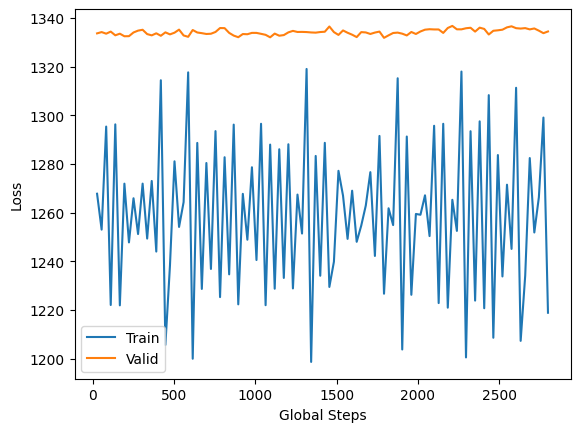

In [58]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(model_path + 'lstm_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
import numpy as np
from sklearn.metrics import classification_report

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for resume, category in test_loader:
            category = category.float().to(device)
            resume = resume.to(device)
            resume_len = torch.tensor([len(seq) for seq in resume], dtype=torch.int64)  # Calculate sequence lengths

            output = model(resume, resume_len)

            output = (output > 0.5).int()

            y_pred.extend(output.tolist())
            y_true.extend(category.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred))


In [84]:
best_model = LSTM(embedding_dim= 400, hidden_dim=128, n_layers=2).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(model_path + 'lstm_model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

Model loaded from <== /content/drive/MyDrive/IC_Evaluation/dl_models/lstm_model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0       0.02      0.40      0.03         5
         1.0       0.01      0.08      0.01        13
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        11
         4.0       0.00      0.00      0.00        11
         5.0       0.00      0.00      0.00        13
         6.0       0.00      0.00      0.00         3
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00         7
        10.0       0.00      0.00      0.00        12
        11.0       0.00      0.00      0.00        13
        12.0       0.00      0.00      0.00        13
        13.0       0.00      0.00      0.00        11
        14.0       0.00      0.00      0.00        13
        15.0       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Rough

In [ ]:
# !pip install -U torchtext

In [ ]:
# faced version issues for torchtext
# !pip install torchtext==0.6.0

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")

In [ ]:
# nlp = spacy.blank("en")

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
# import spacy

# spacy_model = spacy.load("en_core_web_sm")

In [ ]:
# # Fields
# label_field = Field(sequential=False, use_vocab=True, batch_first=True, dtype=torch.long)
# text_field = Field(tokenize=lambda text: [token.text.lower() for token in spacy_model(text)],
#                    include_lengths=True, batch_first=True)
# # resume_text is fearures and category is label
# fields = [('path', text_field),('resume', text_field), ('category', text_field), ('category_label', label_field)]

In [ ]:
# # TabularDataset
# src_folder = '/content/drive/MyDrive/IC_Evaluation/'
# train_data, valid_data, test_data = TabularDataset.splits(path=src_folder, train='final_train.csv',
#                                                           validation='final_validation.csv',
#                                                           test='final_test.csv',
#                                                           format='CSV', fields=fields, skip_header=True)

In [ ]:
# # making label vocab
# label_field.build_vocab(train_data)

In [ ]:
# # Get the label vocabulary from the Field
# label_vocab = label_field.vocab

# # Reverse the mapping of integer index to text label
# index_to_label = {index: label for label, index in label_vocab.stoi.items()}

# # Print the mapping
# k =0
# print("Integer Index to Text Label Mapping:")
# for index, label in index_to_label.items():
#   if k==5:
#     break
#   print(f"Index: {index}, Text Label: {label}")
#   k+=1


In [ ]:
# label_vocab = label_field.vocab
# len(label_vocab)

25

In [ ]:
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

# tokenizer = get_tokenizer(spacy_model)
# train_iter = train_data

# def yield_tokens(data_iter):
#   for _, text in data_iter:
#     yield tokenizer(text)

# vocab = build_vocab_from_iterator(yield_tokens(train_iter))
# # vocab.set_default_index(vocab["<unk>"])

1772lines [02:31, 11.70lines/s]


In [ ]:
# test_pipeline = lambda x: vocab(tokenizer(x))
# label_pipeline = lambda x: int(x)

In [ ]:
# vocab[12]

0

In [ ]:
# making vocabulary
# text_field.build_vocab(train_data, min_freq=3)

cuda:0


In [ ]:
# # making vocabulary for train data
# text_field.build_vocab(train_data, min_freq=3)

# # Iterators
# train_iter = BucketIterator(train_data, batch_size=32, sort_key=lambda x: len(x.resume),
#                             device=device, sort=True, sort_within_batch=True)
# valid_iter = BucketIterator(valid_data, batch_size=32, sort_key=lambda x: len(x.resume),
#                             device=device, sort=True, sort_within_batch=True)
# test_iter = BucketIterator(test_data, batch_size=32, sort_key=lambda x: len(x.resume),
#                             device=device, sort=True, sort_within_batch=True)

In [ ]:
# text_field

In [ ]:
# print("Size of TEXT vocabulary:",len(text_field.vocab))

Size of TEXT vocabulary: 14746


In [ ]:
# #Commonly used words
# print(text_field.vocab.freqs.most_common(10))

[('state', 11396), ('company', 10843), ('city', 10677), ('management', 8659), ('name', 8324), ('sales', 5871), ('business', 5778), ('skills', 5507), ('customer', 5453), ('new', 4536)]


In [ ]:
# print("Label Field Attributes:")
# print("Sequential:", label_field.sequential)
# print("Use Vocab:", label_field.use_vocab)
# print("Batch First:", label_field.batch_first)
# print("dtype:", label_field.dtype)

Label Field Attributes:
Sequential: False
Use Vocab: True
Batch First: True
dtype: torch.int64


In [ ]:
# # Iterate through the dataset and print the processed labels
# k = 0
# for example in train_data:  # Change to valid_data or test_data if needed
#     if k==5:
#       break
#     processed_label = example.category
#     print("Processed Label:", processed_label)
#     k+=1


Processed Label: ACCOUNTANT
Processed Label: BANKING
Processed Label: INFORMATION-TECHNOLOGY
Processed Label: AVIATION
Processed Label: ARTS


In [ ]:
# class classifier(nn.Module):

#     #define all the layers used in model
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
#                  bidirectional, dropout):

#         #Constructor
#         super().__init__()

#         #embedding layer
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)

#         #lstm layer
#         self.lstm = nn.LSTM(embedding_dim,
#                            hidden_dim,
#                            num_layers=n_layers,
#                            bidirectional=bidirectional,
#                            dropout=dropout,
#                            batch_first=True)

#         #dense layer
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)

#         #activation function
#         self.act = nn.Sigmoid()

#     def forward(self, text, text_lengths):

#         #text = [batch size,sent_length]
#         embedded = self.embedding(text)
#         #embedded = [batch size, sent_len, emb dim]

#         #packed sequence
#         packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)

#         packed_output, (hidden, cell) = self.lstm(packed_embedded)
#         #hidden = [batch size, num layers * num directions,hid dim]
#         #cell = [batch size, num layers * num directions,hid dim]

#         #concat the final forward and backward hidden state
#         hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

#         #hidden = [batch size, hid dim * num directions]
#         dense_outputs=self.fc(hidden)

#         #Final activation function
#         outputs=self.act(dense_outputs)

#         return outputs

In [ ]:
model = LSTM(embedding_dim= 400, hidden_dim=128, n_layers=2).to(device)
# size_of_vocab = len(text_field.vocab)
# embedding_dim = 100
# num_hidden_nodes = 32
# num_output_nodes = 1
# num_layers = 2
# bidirection = True
# dropout = 0.2

# #instantiate the model
# model_2 = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,
#                    bidirectional = True, dropout = dropout)

# model_2.cuda()

#defining optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.9), eps=1e-08, weight_decay=0)

In [ ]:
train(model=model, optimizer=optimizer, num_epochs=10)

ValueError: ignored

In [ ]:
# resume_len = resume_len.to('cpu').

for batch in train_iter:
    for text_sequence in batch.resume:
        if len(text_sequence) == 0:
            print("Empty sequence found:", text_sequence)


In [ ]:
for batch in valid_iter:
    print(batch.__dict__.keys())


dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'resume', 'category'])
dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 're

In [ ]:
for example in train_data:
    if len(example.resume) == 0:
        print("Found zero-length sequence in train data:", example.resume)

for example in valid_data:
    if len(example.resume) == 0:
        print("Found zero-length sequence in valid data:", example.resume)

for example in test_data:
    if len(example.resume) == 0:
        print("Found zero-length sequence in test data:", example.resume)


In [54]:
# https://colab.research.google.com/gist/SauravMaheshkar/168f0817f0cd29dd4048868fb0dd4401/lstms-in-pytorch.ipynb#scrollTo=zxlsEhz4w3mT
# https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/
# https://colab.research.google.com/drive/1cpn6pk2J4liha9jgDLNWhEWeWJb2cdch?usp=sharing#scrollTo=N1T5QcSENZ0z
# https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df
# https://www.youtube.com/watch?v=f-86-HcYYi8
# https://www.youtube.com/watch?v=8gAUjBi330g

In [ ]:
#https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks
# https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch
# https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing